In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision ultralytics opencv-python pillow numpy matplotlib

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 88.1M/88.1M [00:02<00:00, 41.9MB/s]



0: 640x640 1 person, 73.6ms
Speed: 21.0ms preprocess, 73.6ms inference, 404.7ms postprocess per image at shape (1, 3, 640, 640)
Step   0: Content 0.00 | Style 42.06 | TV 0.00000
Step  20: Content 0.92 | Style 6.29 | TV 0.00000
Step  40: Content 0.82 | Style 2.62 | TV 0.00000
Step  60: Content 0.73 | Style 1.54 | TV 0.00000
Step  80: Content 0.68 | Style 1.14 | TV 0.00000
Step 100: Content 0.65 | Style 0.94 | TV 0.00000
Step 120: Content 0.65 | Style 1.32 | TV 0.00000
Step 140: Content 0.68 | Style 1.58 | TV 0.00000
Step 160: Content 0.62 | Style 0.91 | TV 0.00000
Step 180: Content 0.59 | Style 0.80 | TV 0.00000
Step 200: Content 0.63 | Style 1.78 | TV 0.00000
Step 220: Content 0.64 | Style 1.32 | TV 0.00000
Step 240: Content 0.59 | Style 0.80 | TV 0.00000
Step 260: Content 0.56 | Style 0.65 | TV 0.00000
Step 280: Content 0.55 | Style 0.64 | TV 0.00000
Step 300: Content 0.60 | Style 1.60 | TV 0.00000
Step 320: Content 0.64 | Style 1.52 | TV 0.00000
Step 340: Content 0.58 | Style 0.84 |

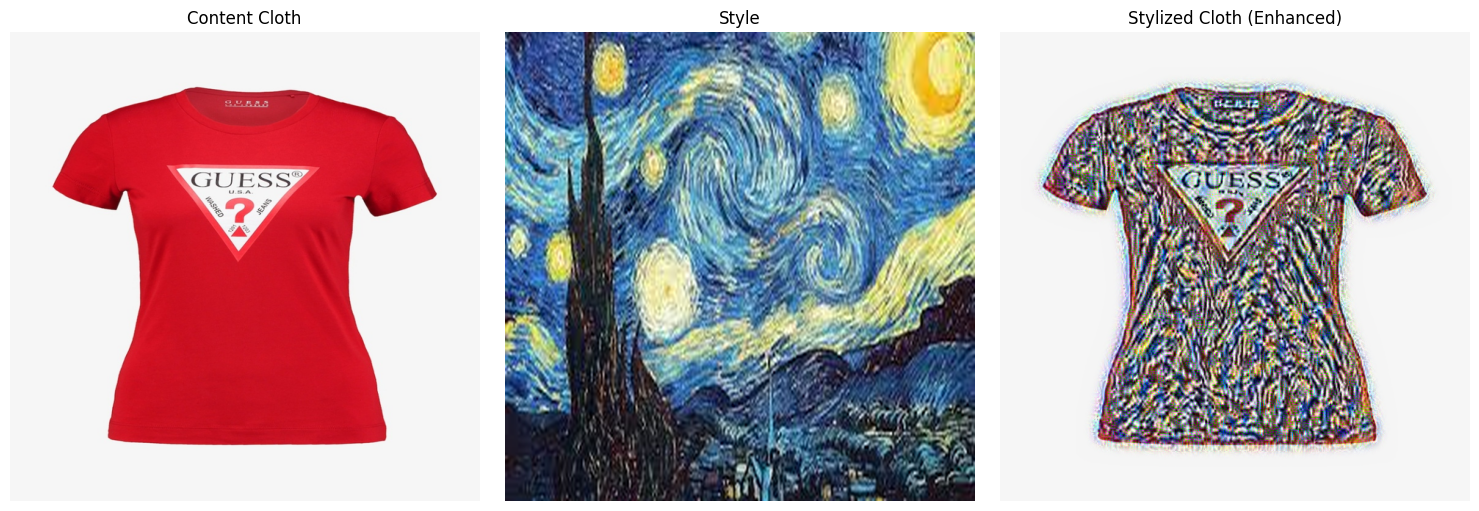

✅ Enhanced stylized cloth saved to /content/drive/MyDrive/styled_cloth_result3.jpg


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image, ImageFilter
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2  # For more robust mask blurring

# ==== Configuration ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 640 # Increased image size for better detection
CLOTH_IMAGE_PATH = '/content/drive/MyDrive/00070_00.jpg'
STYLE_IMAGE_PATH = '/content/drive/MyDrive/art6.jpg'
VGG_WEIGHTS_PATH = '/content/drive/MyDrive/vgg19-dcbb9e9d.pth'
RESULT_SAVE_PATH = '/content/drive/MyDrive/styled_cloth_result3.jpg'

# ==== Image Preprocessing Utilities ====
def load_and_resize(path, size=256):
    img = Image.open(path).convert('RGB').resize((size, size), Image.LANCZOS)
    return img

def pil_to_tensor(img):
    return transforms.ToTensor()(img).unsqueeze(0).to(DEVICE)

def tensor_to_pil(tensor):
    t = tensor.clone().detach().cpu().squeeze(0)
    t = (t * 255).clamp(0,255).byte()
    return transforms.ToPILImage()(t)

def get_features(x, model, layers):
    feats = []
    for idx, layer in enumerate(model):
        x = layer(x)
        if str(idx) in layers:
            feats.append(x)
    return feats

def gram_matrix(t):
    b, c, h, w = t.size()
    f = t.view(b * c, h * w)
    return (f @ f.t()) / f.numel()

def resize_mask(mask, target_tensor):
    return F.interpolate(mask, size=target_tensor.shape[2:], mode='nearest')

def total_variation_loss(x):
    return torch.mean(torch.abs(x[:,:,:,1:] - x[:,:,:,:-1])) + \
           torch.mean(torch.abs(x[:,:,1:,:] - x[:,:,:-1,:]))


def blur_mask(mask_tensor, sigma=2.5):
    if mask_tensor.ndim == 4 and mask_tensor.shape[0] == 1 and mask_tensor.shape[1] == 1:
        arr = mask_tensor.squeeze().cpu().numpy()
        arr_blur = cv2.GaussianBlur(arr, (0, 0), sigma)
        blur = torch.from_numpy(arr_blur).float().clamp(0, 1).to(mask_tensor.device)
        return blur.unsqueeze(0).unsqueeze(0)
    else:
        return mask_tensor # Return original if not a single-channel mask tensor

# ==== Load Images ====
cloth_img = load_and_resize(CLOTH_IMAGE_PATH, IMG_SIZE)
style_img = load_and_resize(STYLE_IMAGE_PATH, IMG_SIZE)
content_tensor = pil_to_tensor(cloth_img)
style_tensor = pil_to_tensor(style_img)

# ==== YOLOv8 Segmentation Mask (soft) ====
# Try a different YOLO model (e.g., yolov8m-seg.pt or yolov8l-seg.pt)
yolo = YOLO('yolov8l-seg.pt')
results = yolo(cloth_img, imgsz=IMG_SIZE, conf=0.3, iou=0.5) # Increased confidence threshold slightly

mask = None
if results[0].masks is not None and len(results[0].masks.data) > 0:
    # Assuming the first detected object is the cloth
    mask_np = results[0].masks.data.cpu().numpy()[0]
    mask = torch.from_numpy(mask_np).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    mask = mask / mask.max()
    mask = blur_mask(mask, sigma=7.0)  # Further soften mask edges for smooth coverage, increased sigma

if mask is None:
    print("Warning: No object detected by YOLOv8. Applying style transfer to the entire image.")
    # Create a mask of ones if no object is detected to apply style to the whole image
    mask = torch.ones_like(content_tensor[:, :1, :, :])


# ==== VGG19 Feature Extraction ====
vgg = models.vgg19(weights=None)
vgg.load_state_dict(torch.load(VGG_WEIGHTS_PATH, map_location=DEVICE))
vgg_features = vgg.features.to(DEVICE).eval()
content_layers = ["21"]
# Focus on mid-deep style layers for consistent pattern transfer
style_layers = ["5", "10", "19", "28"]

with torch.no_grad():
    content_feat = get_features(content_tensor, vgg_features, content_layers)[0]
    style_feats = get_features(style_tensor, vgg_features, style_layers)
    style_grams = [gram_matrix(f) for f in style_feats]

# ==== Style Transfer Optimization ====
input_img = content_tensor.clone().requires_grad_(True)
optimizer = optim.Adam([input_img], lr=0.06)
num_steps = 600
alpha, beta, gamma = 1, 3e6, 2e-6  # Adjusted weights for strong content, smooth style

for step in range(num_steps):
    optimizer.zero_grad()
    gen_style_feats = get_features(input_img, vgg_features, style_layers)
    gen_content_feat = get_features(input_img, vgg_features, content_layers)[0]

    c_mask = resize_mask(mask, gen_content_feat)
    content_loss = alpha * F.mse_loss(gen_content_feat * c_mask, content_feat * c_mask)

    style_loss = 0
    # Apply mask only to generated features for dense, even transfer
    for f, g in zip(gen_style_feats, style_grams):
        s_mask = resize_mask(mask, f)
        style_loss += F.mse_loss(gram_matrix(f * s_mask), g)
    style_loss = beta * style_loss

    tv_loss = gamma * total_variation_loss(input_img)

    total_loss = content_loss + style_loss + tv_loss
    total_loss.backward()
    optimizer.step()

    with torch.no_grad():
        input_img.clamp_(0, 1)
    if step % 20 == 0 or step == num_steps-1:
        print(f'Step {step:3d}: Content {content_loss.item():.2f} | Style {style_loss.item():.2f} | TV {tv_loss.item():.5f}')

# ==== Masked Blending & Output ====
with torch.no_grad():
    stylized = input_img.detach()
    mask_resz = resize_mask(mask, stylized).expand(-1, 3, -1, -1)
    # Blend the stylized image with the original content based on the mask
    blended = stylized * mask_resz + content_tensor * (1 - mask_resz)


result_pil = tensor_to_pil(blended)
result_pil.save(RESULT_SAVE_PATH)

# ==== Visualization ====
plt.figure(figsize=(15, 5))
images = [(cloth_img, "Content Cloth"), (style_img, "Style"), (result_pil, "Stylized Cloth (Enhanced)")]
for idx, (img, title) in enumerate(images):
    plt.subplot(1,3,idx+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()
print(f"✅ Enhanced stylized cloth saved to {RESULT_SAVE_PATH}")